In [1]:
# Resources

# deactivate buggy jupyter completion
%config Completer.use_jedi = False

import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import os
import sklearn
import json

# setup the resources location
PATH_TO_RESOURCES = "./data/"

train_data_x = np.memmap(PATH_TO_RESOURCES + "train_data_x.dat", mode='r',
                        dtype=np.float32, shape=(256, 240, 240, 4))
train_data_y = np.memmap(PATH_TO_RESOURCES + "train_data_y.dat", mode='r',
                        dtype=np.uint8, shape=(256, 240, 240))
test_data_x = np.memmap(PATH_TO_RESOURCES + "test_data_x.dat", mode='r',
                        dtype=np.float32, shape=(29, 240, 240, 4))

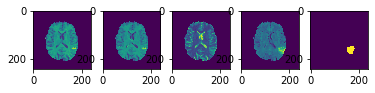

In [2]:
def display(array_x, array_y, brain):
    plt.subplot(151)
    plt.imshow(array_x[brain, :, :, 0])
    plt.subplot(152)
    plt.imshow(array_x[brain, :, :, 1])
    plt.subplot(153)
    plt.imshow(array_x[brain, :, :, 2])
    plt.subplot(154)
    plt.imshow(array_x[brain, :, :, 3])
    plt.subplot(155)
    plt.imshow(array_y[brain, :, :])
    plt.show()

display(train_data_x, train_data_y, 2)

In [3]:
nb_train_slices = 20

In [4]:
train_data_sample_ids = np.random.choice(len(train_data_x), nb_train_slices, replace=False)
print(train_data_sample_ids)
train_data_x_sample = [train_data_x[x] for x in train_data_sample_ids]

[ 95  36 106 130 101 124 132  90 171 120  74 147  14  63 189  42  64 209
 185 104]


In [5]:
train_data_y_sample = [train_data_y[x] for x in train_data_sample_ids]

In [6]:
train_data_x_sample = np.array(train_data_x_sample)
train_data_x_sample.shape, train_data_x_sample
train_data_y_sample = np.array(train_data_y_sample)
train_data_x_sample.shape, train_data_y_sample.shape

((20, 240, 240, 4), (20, 240, 240))

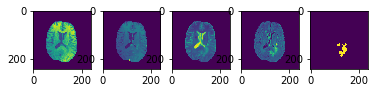

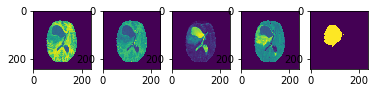

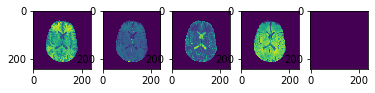

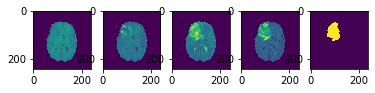

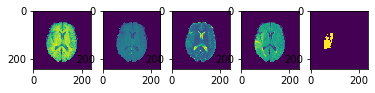

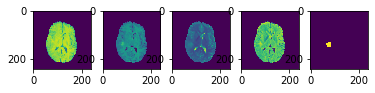

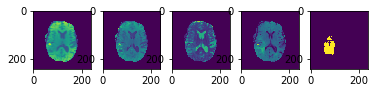

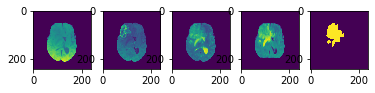

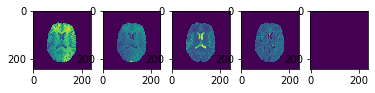

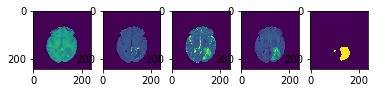

In [7]:
for i in range(10):
    display(train_data_x_sample, train_data_y_sample, i)

In [8]:
nb_val_slices = 30

In [9]:
rtx = []
for i in range(len(train_data_x)):
    if not (i in train_data_sample_ids): 
        rtx.append(i)
print(len(rtx))
val_data_sample_ids = np.random.choice(rtx, nb_val_slices, replace=False)
val_data_x_sample = [train_data_x[x] for x in val_data_sample_ids]
val_data_x_sample = np.array(val_data_x_sample)
val_data_x_sample.shape

236


(30, 240, 240, 4)

In [10]:
val_data_y_sample = [train_data_y[x] for x in val_data_sample_ids]
val_data_y_sample = np.array(val_data_y_sample)
val_data_y_sample.shape

(30, 240, 240)

In [11]:
def slices_to_masks(slices):
    '''
    Computes the foreground masks for each slice in a stack.

    Arguments
    ---------
    slices: numpy.array, shape (NUM_SLICES, 240, 240, 4)
        an array of slices for which every pixel belonging to the background has 
        the smallest possible value in each modality.

    Returns
    -------
    slices_masks: numpy.array, shape (NUM_SLICES, 240, 240), dtype numpy.bool
        the maks for each of the original slices indicating the foreground pixels.

    '''
    if slices.ndim != 4:
        raise ValueError("slices_to_masks expects as parameter an array of 4 dimensions (numslices, rows, cols, features)."
                         " It got instead an array of %s dimensions" % (slices.ndim, ))
    slices_min = np.min(slices, axis=(1, 2))
    slices_masks = np.all(slices > slices_min[:, np.newaxis, np.newaxis, :],
                          axis=-1)
    return slices_masks

In [12]:
mask_train_data_sample = slices_to_masks(train_data_x_sample)
mask_train_data_sample.shape

(20, 240, 240)

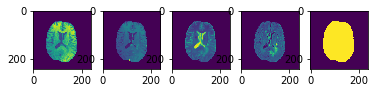

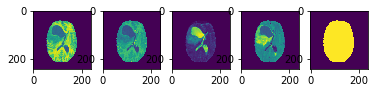

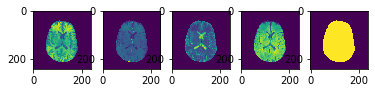

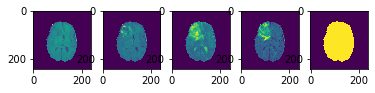

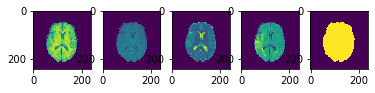

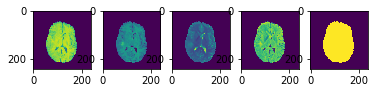

In [13]:
for ii in range(train_data_x_sample.shape[0])[:6]:
    # display_slices(train_data_x_sample[ii], mask_train_data_sample[ii])
    display(train_data_x_sample, mask_train_data_sample, ii)

In [14]:
train_data_x_sample.shape, mask_train_data_sample.shape

((20, 240, 240, 4), (20, 240, 240))

In [15]:
train_data_x_sample = (train_data_x_sample[mask_train_data_sample])
train_data_y_sample = (train_data_y_sample[mask_train_data_sample])

train_data_x_sample.shape, train_data_y_sample.shape
# we expect shapes like:
# - (169144, 4) for train_data_x_sample
# - (169144,) for train_data_y_sample

((344219, 4), (344219,))

In [16]:
from sklearn.svm import SVC
svclassifier = SVC(gamma='auto')

In [17]:
# Check the shape of your inputs before firing the training!
train_data_x_sample.shape, train_data_y_sample.shape

((344219, 4), (344219,))

In [18]:
svclassifier.fit(train_data_x_sample,train_data_y_sample)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [19]:
val_data_x_sample.shape

(30, 240, 240, 4)

In [20]:
mask_val_data_sample = slices_to_masks(val_data_x_sample)
val_data_x_sample = (val_data_x_sample[mask_val_data_sample])
val_data_y_sample = (val_data_y_sample[mask_val_data_sample])

In [21]:
# evaluate
score = svclassifier.score(val_data_x_sample, val_data_y_sample)
print("score ", score)

score  0.9518234150519379


In [22]:
from sklearn.metrics import classification_report, confusion_matrix  

In [23]:
import warnings

def dice_score(y_true, y_pred):
    '''Compute the Dice coefficient between true and predicted values.'''
    for var, name in ((y_true, "y_true"), (y_pred, "y_pred")):
        if not isinstance(var, np.ndarray):
            raise ValueError("dice_score: `%s` must be a numpy array. Got object of type %s instead."
                             % (name, type(var)))
        if var.ndim != 1:
            raise ValueError("dice_score: `%s` must be 1-dimensional. Got %s.ndim=%d instead."
                             % (name, name, var.ndim))
        if not (var.dtype == np.uint8 or var.dtype == np.bool):
            warnings.warn("dice_score: `%s` should be either of type np.uint8 or np.bool. "
                          "Got %s instead. "
                          "Values will be projected on {0,1}."
                          % (name, var.dtype))

    if y_true.shape != y_pred.shape:
        raise ValueError("dice_score: `y_true` and `y_pred` must have the same shape. "
                         "Got y_true.shape=%s and y_pred.shape=%s instead."
                         % (y_true.shape, y_pred.shape))
    y_true_ = y_true != 0  # Project over {False,True}
    y_pred_ = y_pred != 0
    # The boolean union removes the duplicate intersection!
    union = np.sum(y_true_ + y_pred_)
    if union == 0:
        warnings.warn("dice_score: neither `y_true` nor `y_pred` contain positive values."
                      " The score is ill-defined. Returning `1.` without much faith...")
        return 1.
    inter = np.sum(y_true_ * y_pred_)
    # We need to re-add the intersection or we get the Jaccard index
    return 2 * inter / (union + inter)

In [24]:
dscore = dice_score(val_data_y_sample.reshape((-1,)), svclassifier.predict(val_data_x_sample))
dscore

0.7403466130168813

In [25]:
svclassifier = SVC(gamma='auto', kernel='rbf')

In [26]:
svclassifier.fit(train_data_x_sample,train_data_y_sample)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [27]:
val_data_ypred_sample = svclassifier.predict(val_data_x_sample)

In [28]:
dscore = dice_score(val_data_y_sample.reshape((-1,)), svclassifier.predict(val_data_x_sample))
dscore

0.7403466130168813

In [29]:
from sklearn.neural_network import MLPClassifier

In [30]:
mlpclf1 = MLPClassifier(alpha=1e-6, max_iter=200, solver='adam',
                        activation='relu', batch_size=256)
mlpclf1.fit(train_data_x_sample, train_data_y_sample)

MLPClassifier(activation='relu', alpha=1e-06, batch_size=256, beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [31]:
val_data_ypred_sample = mlpclf1.predict(val_data_x_sample)

In [32]:
dscore = dice_score(val_data_y_sample.reshape((-1,)), val_data_ypred_sample)
dscore

0.7338403411132803

In [33]:
from sklearn.ensemble import RandomForestClassifier

In [34]:
rfclass = RandomForestClassifier(n_estimators=500, max_depth=10)
rfclass.fit(train_data_x_sample, train_data_y_sample)
val_data_ypred_sample = rfclass.predict(val_data_x_sample)
dscore = dice_score(val_data_y_sample.reshape((-1,)), val_data_ypred_sample)
dscore

0.7376281633378771

In [37]:
# Eval on Test Data

In [38]:
print('test_data_x shape ', test_data_x.shape)
# test_mask = slices_to_masks(test_data_x)
# test_data_x_masked = test_data_x[test_mask]
# print('test_data_x_masked shape ', test_data_x_masked.shape)
tsize = test_data_x.shape[0] * test_data_x.shape[1] * test_data_x.shape[2]

test_data_x_pix = test_data_x.reshape((tsize, 4))
print('test_data_x_pix shape ', test_data_x_pix.shape)


# Best Classifier
bestclassifier = mlpclf1

test_data_ypred = bestclassifier.predict(test_data_x_pix)  # prediction

test_data_x shape  (29, 240, 240, 4)
test_data_x_pix shape  (1670400, 4)


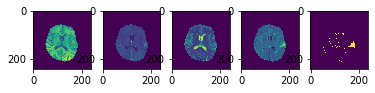

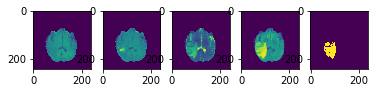

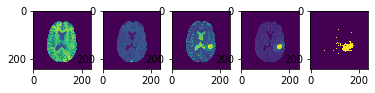

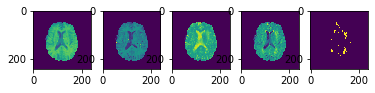

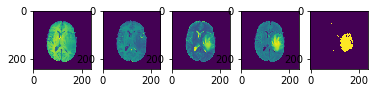

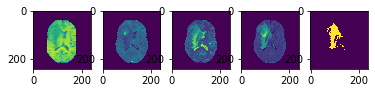

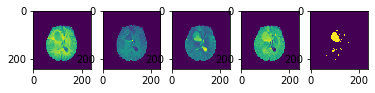

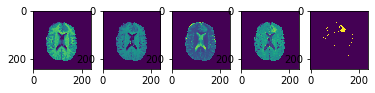

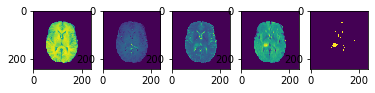

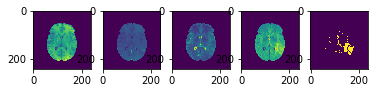

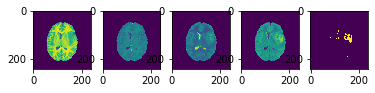

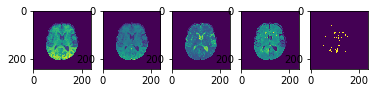

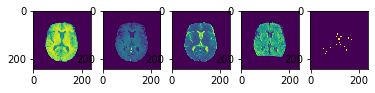

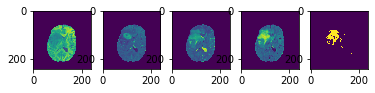

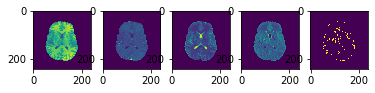

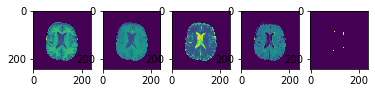

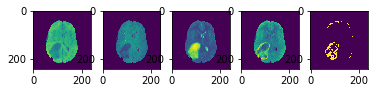

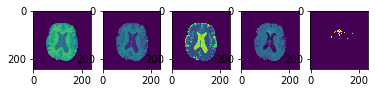

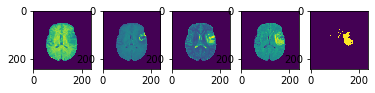

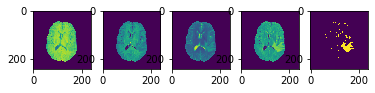

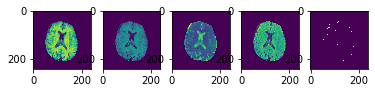

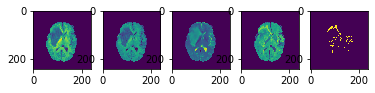

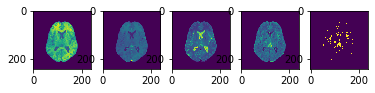

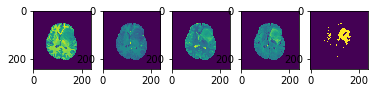

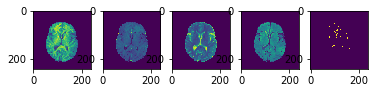

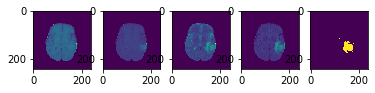

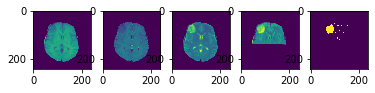

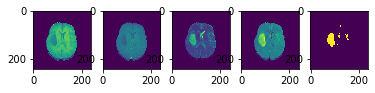

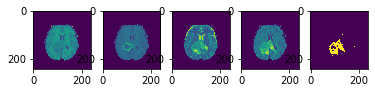

In [39]:
test_res = test_data_ypred.reshape((29, 240, 240))
for i in range(len(test_data_x)):
    display(test_data_x, test_res, i)

In [40]:
# Export Results

In [41]:
def export_test_predictions(test_ypred, filename='test_data_ypred.dat'):
    expected_shape = (29, 240, 240)
    expected_dtype = np.uint8
    # Check shape
    if test_ypred.shape != expected_shape:
        raise ValueError("export_test_predictions: your prediction do not have the right shape."
                         " Expected shape %s but got %s instead." % (expected_shape, test_ypred.shape))
    # Check dtype
    if test_ypred.dtype != expected_dtype:
        raise ValueError("export_test_predictions: your prediction do not have the right dtype."
                         " Expected dtype %s but got %s instead." % (expected_dtype, test_ypred.dtype))
    # Check values
    if np.sum(test_ypred == 1) + np.sum(test_ypred == 0) != np.prod(expected_shape):
        raise ValueError("export_test_predictions: your prediction should contain only binary (0 and 1)"
                         " values. It seems that you have other values.")
    # Seems ok
    test_data_ypred = np.memmap(filename, mode="w+", dtype=expected_dtype, shape=expected_shape)
    test_data_ypred[...] = test_ypred  # copy values
    # The buffer is automatically flushed on disk upon object destruction but can also be explicit
    test_data_ypred.flush()
    print("Wrote '%s'." % filename)

In [42]:
export_test_predictions(test_data_ypred.reshape((29, 240, 240)))

Wrote 'test_data_ypred.dat'.
